# EDA

In [9]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [10]:
press = pd.read_csv('./data/press.csv')
dtm = pickle.load(open('./data/df_dtm.pkl', 'rb'))

## Fréquence des termes

### Analyse

In [11]:
press

,newspaper,text,clean_text,relevent_text,stemmed_text
0,20minutes,CORONAVIRUS Après une alerte lancée il y a tro...,coronavirus apres une alerte lancee il y a tro...,coronavirus alerte lancee semaines foyer conta...,coronavirus alert lance semain foi contamin ch...
1,bfm,"Parmi les trois foyers identifiés, l'un se tro...",parmi les trois foyers identifies l un se trou...,parmi foyers identifies trouve entreprise feca...,parm foyer identif trouv entrepris fecamp ehpa...
2,cnews,La France a enregistré 16 décès supplémentaire...,la france a enregistre <NB> deces supplementai...,france enregistre deces supplementaires lies c...,franc enregistr dec supplementair li coronavir...
3,lacroix,Ne pas baisser la garde. C’est en résumé le me...,ne pas baisser la garde c est en resume le mes...,baisser garde resume message lance organisatio...,baiss gard resum messag lanc organis mondial s...
4,ledauphine,Un cas positif de Covid-19 a été détecté ce ve...,un cas positif de coronavirus a ete detecte ce...,cas positif coronavirus detecte parmi personne...,cas posit coronavirus detect parm personnel en...
5,lefigaro,"Sur un marché parisien, les commerçants prenne...",sur un marche parisien les commerçants prennen...,marche parisien commerçants prennent mesures l...,march parisien commerc prennent mesur limit co...
6,lemonde,"Le Brésil comptait, samedi 20 juin, près de 1 ...",le bresil comptait samedi <NB> juin pres de <N...,bresil comptait pres million cas coronavirus e...,bresil compt pre million cas coronavirus europ...
7,lesechos,Par Les Echos\n\nPublié le 20 juin 2020 à 18h4...,par les echos publie le <NB> juin <NB> a <NB> ...,echos publie nuit doit revoir jour patrons dis...,echos publ nuit doit revoir jour patron discot...


In [12]:
from collections import Counter

def count_words(newspaper):
    counter = Counter()
    for word in press[press['newspaper'] == newspaper]['relevent_text'].values[0].split(' '):
        counter[word] += 1
    return counter

count_words('bfm').most_common(10)

[('coronavirus', 29),
 ('cas', 25),
 ('plus', 20),
 ('sante', 16),
 ('contamination', 10),
 ('virus', 10),
 ('situation', 10),
 ('personnes', 9),
 ('sein', 9),
 ('deces', 9)]

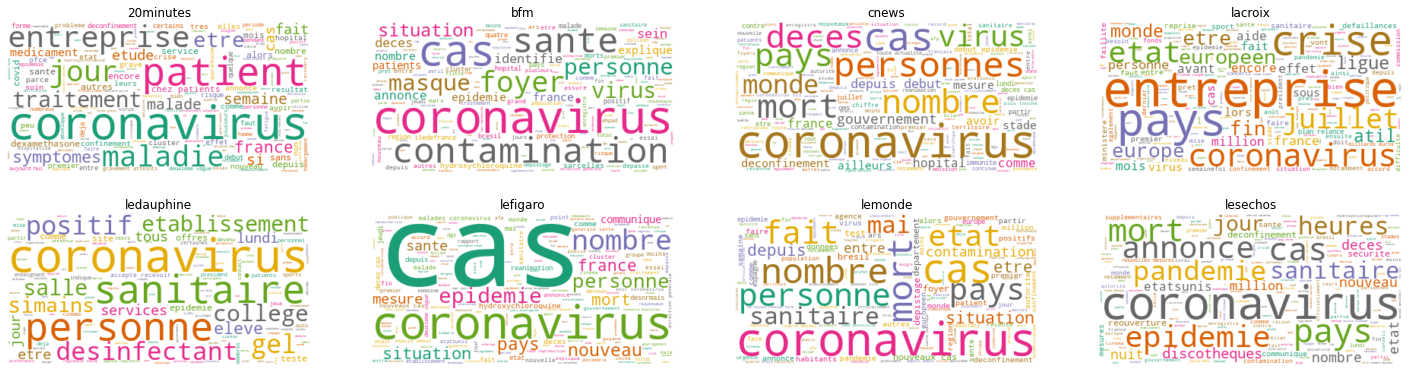

In [13]:
from wordcloud import WordCloud

stopwords = ['a', '<NB>', 'ete', 'plus', 'cette', 'NB', 'nb', '<nb>', 'selon']
wc = WordCloud(stopwords=stopwords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=0)

# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [25, 10]

# Create subplots for each comedian
for index, newspaper in enumerate(press['newspaper'].values):
    wc.generate(press[press['newspaper'] == newspaper]['relevent_text'].values[0])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(newspaper)
    
plt.show()

### Résultats

* Le 20minutes parle de la pathologie, du patient, du traitement ; des aspects plutôt médicaux
* CNEWS est plutôt pessimiste et parle des cas, morts ainsi que de leur nombre
* Lacroix s'intéresse aux entrprises et à l'économie

## Les thèmes

In [63]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

def tokenize(text, stop_words=[]):
    return [w for w in text.split(' ') if w not in stop_words]

def get_lda(press, stop_words=set()):
    common_texts = [tokenize(text, stop_words=stop_words) for text in press['relevent_text']]
    common_dictionary = Dictionary(common_texts)
    common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
    return LdaModel(common_corpus, id2word=common_dictionary, num_topics=3, iterations=40, passes=10), common_corpus

In [65]:
def clusterize(lda, common_corpus):
    clusters = {}
    for i, newspaper in enumerate(press['newspaper']):
        highest_proba = 0
        id_max = 0
        for cluster_id, proba in lda[common_corpus[i]]:
            if cluster_id not in clusters:
                clusters[cluster_id] = []
            if highest_proba < proba:
                id_max = cluster_id
                highest_proba = proba
        clusters[id_max].append(newspaper)
    return clusters

lda, common_corpus = get_lda(press)
clusters = clusterize(lda, common_corpus)

print("============= Clusters ==================")
pprint(clusters)
print("============= Topics ==================")
pprint(lda.print_topics())

============= Clusters ==================
{0: ['cnews', 'ledauphine', 'lefigaro', 'lemonde', 'lesechos'],
 1: ['bfm', 'lacroix'],
 2: ['20minutes']}
============= Topics ==================
[(0,
  '0.013*"coronavirus" + 0.011*"cas" + 0.010*"plus" + 0.006*"epidemie" + '
  '0.006*"pays" + 0.006*"nombre" + 0.006*"personnes" + 0.005*"morts" + '
  '0.005*"sante" + 0.005*"depuis"'),
 (1,
  '0.009*"plus" + 0.007*"coronavirus" + 0.006*"cas" + 0.004*"pays" + '
  '0.004*"sante" + 0.004*"france" + 0.003*"entreprises" + 0.003*"etre" + '
  '0.003*"virus" + 0.003*"crise"'),
 (2,
  '0.013*"coronavirus" + 0.011*"patients" + 0.006*"plus" + 0.005*"cas" + '
  '0.005*"sante" + 0.004*"france" + 0.004*"chez" + 0.004*"etre" + '
  '0.003*"entreprises" + 0.003*"symptomes"')]


In [57]:
stop_words = set(['coronavirus', 'plus', 'depuis', 'selon', 'si', 'etre', 'comme', 'chez', 'cas', 'sein'])
lda, common_corpus = get_lda(press, stop_words=stop_words)
clusters = clusterize(lda, common_corpus)

print("============= Clusters ==================")
pprint(clusters)
print("\n============= Topics ==================")
pprint(lda.print_topics())

============= Clusters ==================
{0: ['bfm', 'lefigaro'],
 1: ['cnews', 'lemonde', 'lesechos'],
 2: ['20minutes', 'lacroix', 'ledauphine']}

============= Topics ==================
[(0,
  '0.006*"sante" + 0.006*"nombre" + 0.006*"epidemie" + 0.005*"personnes" + '
  '0.005*"deces" + 0.005*"situation" + 0.004*"pays" + 0.004*"france" + '
  '0.004*"nouveau" + 0.004*"virus"'),
 (1,
  '0.006*"pays" + 0.005*"epidemie" + 0.005*"nombre" + 0.005*"morts" + '
  '0.005*"personnes" + 0.004*"sante" + 0.004*"deces" + 0.004*"annonce" + '
  '0.003*"mesures" + 0.003*"nouveaux"'),
 (2,
  '0.008*"patients" + 0.005*"entreprises" + 0.004*"sante" + 0.004*"france" + '
  '0.003*"crise" + 0.003*"symptomes" + 0.003*"fait" + 0.003*"encore" + '
  '0.003*"semaines" + 0.003*"pays"')]


* **Morbidité vs traitement**

In [119]:
morbid_terms = ['mort', 'cas', 'deces', 'morts', 'mauvais']
health_terms = ['sante', 'traitement', 'gueri', 'gueris', 'mesure', 'securite', 'gel']

terms_mt = []
for newspaper in newspapers:
    health_cpt, morbid_cpt = 0, 0
    for mt, ht in zip(morbid_terms, health_terms):
        health_cpt += dtm.loc[newspaper, mt]
        morbid_cpt += dtm.loc[newspaper, ht]
    terms_mt.append((morbid_cpt, health_cpt))

terms_mt = np.array(terms_mt)
terms_mt

array([[46, 30],
       [19, 41],
       [17, 71],
       [ 6, 15],
       [ 6,  4],
       [22, 69],
       [18, 56],
       [ 9, 41]], dtype=int64)

Text(0, 0.5, 'Morbidité')

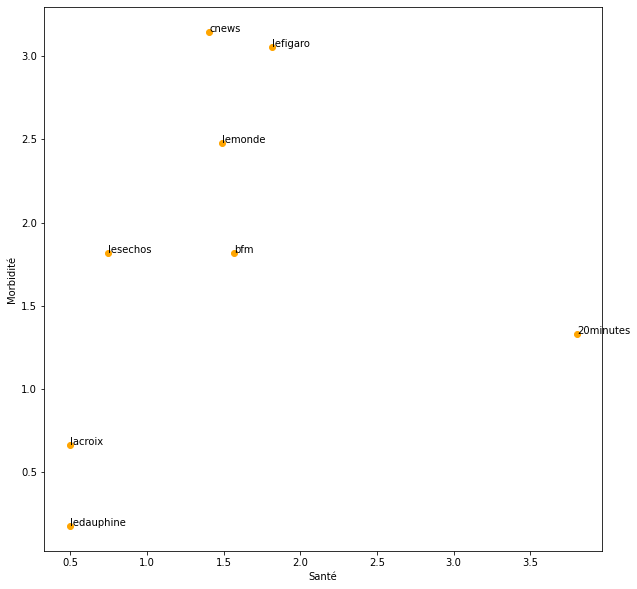

In [120]:
std_terms_mt = terms_mt / np.std(terms_mt, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
for i, newspaper in enumerate(newspapers):
    x = std_terms_mt[i][0]
    y = std_terms_mt[i][1]
    ax.scatter(x, y, c='orange')
    ax.text(x+0.0001, y+0.0001, newspaper)
ax.set_xlabel('Santé')
ax.set_ylabel('Morbidité')

In [91]:
from gensim.models import Word2Vec

size = 50
texts = [tokenize(text, stop_words=stop_words) for text in press['relevent_text']]
w2v = Word2Vec(texts, size=size, window=5, min_count=1, workers=-1)

In [92]:
texts_matrix = []
newspapers = press['newspaper'].values
for text in press['relevent_text']:
    word_vect = np.zeros((size, ))
    length = 0
    for word in tokenize(text, stop_words=stop_words):
        word_vect += w2v.wv[word]
        length += 1
    word_vect /= length
    texts_matrix.append(word_vect)
texts_matrix = np.array(texts_matrix)
texts_matrix.shape

(8, 50)

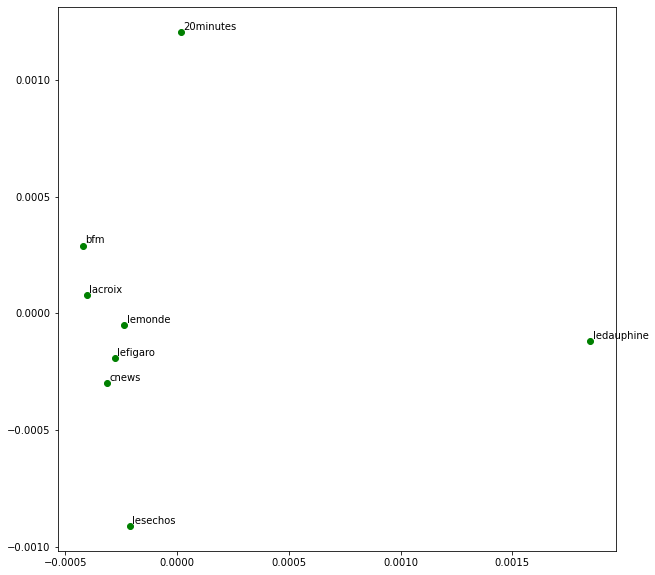

In [93]:
from sklearn.decomposition import PCA

pca = PCA(2)
twodim = pca.fit_transform(texts_matrix)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, newspaper in enumerate(newspapers):
    x = twodim[i,0]
    y = twodim[i,1]
    ax.scatter(x, y, c='green')
    ax.text(x+0.00001, y+0.00001, newspaper)

## Positivité vs négativité & subjectivité

In [20]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer


pol = lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]
sub = lambda x: TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1]

data = press[['newspaper']].copy()
data['polarity'] = press['relevent_text'].apply(pol)
data['subjectivity'] = press['relevent_text'].apply(sub)
data

,newspaper,polarity,subjectivity
0,20minutes,0.064085,0.229987
1,bfm,0.075879,0.155267
2,cnews,0.066429,0.291481
3,lacroix,0.073655,0.281439
4,ledauphine,0.126333,0.173333
5,lefigaro,0.052941,0.159307
6,lemonde,0.072199,0.159969
7,lesechos,0.083420,0.167917


Text(0.5, 0, 'Polarité')

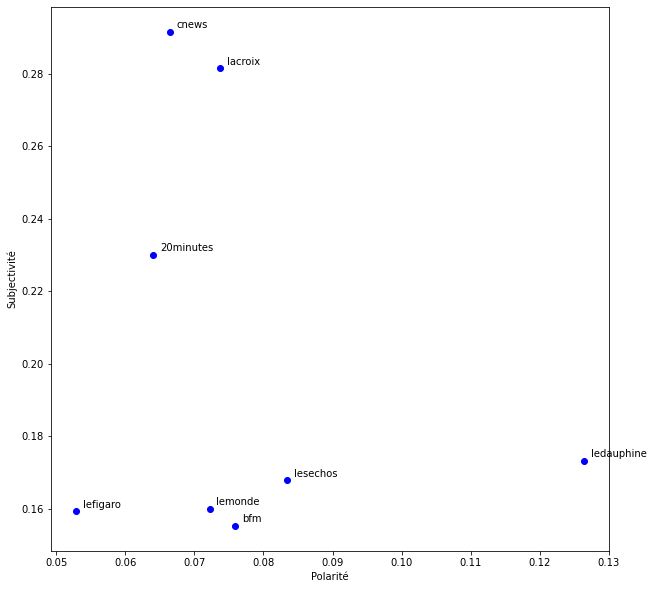

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

for newspaper, row in zip(data['newspaper'], data[['polarity', 'subjectivity']].values):
    x = row[0]
    y = row[1]
    ax.scatter(x, y, color='blue')
    ax.text(x+0.001, y+0.001, newspaper)

ax.set_ylabel('Subjectivité')
ax.set_xlabel('Polarité')

### Résultats

* Les journaux les plus subjectifs ont tendance à être plus négatif que les autres.

## Longueur et nombre de mots par article

In [22]:
from urls import *
from statistics import median

newspapers = URLS.keys()
nb_articles = {newspaper: len(urls) for newspaper, urls in zip(newspapers, URLS)}

def mean_length_sentences(text):
    sentences = text.split('.')
    res = 0
    for sentence in sentences:
        length = len(sentence.split(' '))
        res += length
    return res / len(sentences)

def median_length_sentences(text):
    sentences = text.split('.')
    lengths = []
    for sentence in sentences:
        lengths.append(len(sentence.split(' ')))
    return median(lengths)

words_per_articles = [len(text.split(' ')) / nb_articles[newspaper] for newspaper, text in zip(press['newspaper'], press['text'])]
sentences_mean_lengths = [mean_length_sentences(text) for text in press.set_index('newspaper').loc[newspapers]['text']]
sentences_median_lengths = [median_length_sentences(text) for text in press.set_index('newspaper').loc[newspapers]['text']]

texts_stats = pd.DataFrame()
texts_stats['number of articles'] = nb_articles.values()
texts_stats['words per articles'] = words_per_articles
texts_stats['sentences mean length'] = sentences_mean_lengths
texts_stats['sentences median length'] = sentences_median_lengths
texts_stats = texts_stats.set_index(press['newspaper']).round(2)
texts_stats

,number of articles,words per articles,sentences mean length,sentences median length
newspaper,,,,
20minutes,3,778.00,21.21,21.0
bfm,9,1078.33,22.41,22.0
cnews,5,770.60,19.43,17.0
lacroix,10,597.57,23.71,21.0
ledauphine,7,125.00,27.23,26.5
lefigaro,8,438.12,19.44,18.0
lemonde,8,847.00,20.88,17.0
lesechos,7,427.62,27.47,25.0


Text(0, 0.5, 'Longueur médiane des phrases')

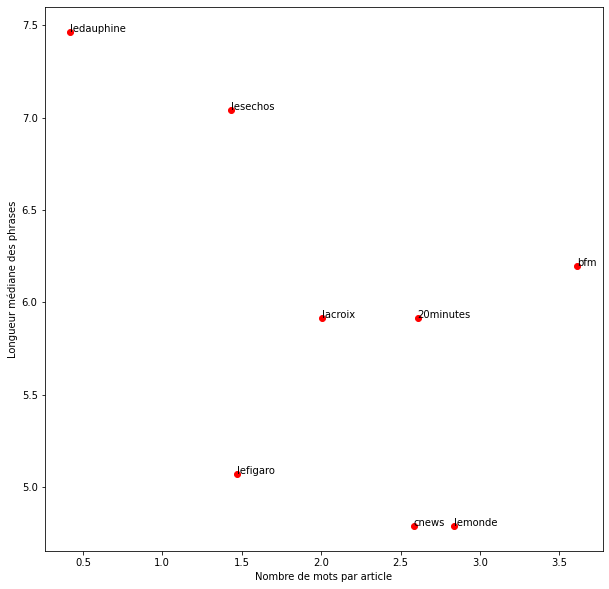

In [101]:
std_texts_stats = texts_stats.copy() / texts_stats.std()  # Standardize
fig, ax = plt.subplots(figsize=(10, 10))
for newspaper, x, y in zip(std_texts_stats.index, std_texts_stats['words per articles'], std_texts_stats['sentences median length']):
    ax.scatter(x, y, c='r')
    ax.text(x+0.0001, y+0.0001, newspaper)
ax.set_xlabel("Nombre de mots par article")
ax.set_ylabel('Longueur médiane des phrases')

### Résultats

* CNEWS et LeMonde produisent les phrases les plus courtes avec 17 et 18 mots par phrase (médian)
* LeFigaro produit les phrases les plus longues avec 27 mots en moyenne
* BFM produit les articles les plus longs avec plus de 1000 mots par article. C'est LeDauphiné qui produit les articles les plus courts avec 124 mots par article.